In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/preprocessed_data%20-%20preprocessed_data.csv'

In [153]:
def numpy_to_tensor(array):
  return torch.from_numpy(array).float()

def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.ndim == 2 else tensor.detach().cpu().numpy().reshape(-1, 2)

In [142]:
class DataLoader():

  def __init__(self, url):
    self.url = url
    self.data = pd.read_csv(url)

    self.embeddings = self.data['embeddings']
    self.embeddings = np.array([eval(i) for i in self.embeddings])

    self.mol_weights = self.data['Molecular Weight']
    self.mol_weights = np.array([i for i in self.mol_weights])

    self.targets = self.data[['a','b']]
    self.targets = np.array(self.targets).T


  def get_sample(self, index):
    return self.embeddings[:, index]

  def get_target(self, index):
    return self.targets[:, index]

In [167]:
class PINN(nn.Module):

    def __init__(self, dataloader, layers_dim):
        super(PINN, self).__init__()

        self.dataloader = dataloader
        self.scaler = StandardScaler()

        self.X = numpy_to_tensor(self.dataloader.embeddings)
        self.X_mol_weights = numpy_to_tensor(self.dataloader.mol_weights)
        self.Y = self.dataloader.targets.T  # (N, 2)

        self.Y = self.scaler.fit_transform(self.Y)
        self.Y = numpy_to_tensor(self.Y)

        indices = self.X.shape[0]
        self.train_indices, self.test_indices = train_test_split(np.arange(indices), test_size=0.2, random_state=42)

        self.X_train = self.X[self.train_indices]
        self.X_test = self.X[self.test_indices]

        self.X_mol_weights_train = self.X_mol_weights[self.train_indices]
        self.X_mol_weights_test = self.X_mol_weights[self.test_indices]

        # **Fixed Indexing**
        self.Y_train = self.Y[self.train_indices]  # (N_train, 2)
        self.Y_test = self.Y[self.test_indices]  # (N_test, 2)

        self.layers_dim = layers_dim
        self.hidden_layers = []

        for l in self.layers_dim:
            self.hidden_layers.append(nn.Linear(l[0], l[1]))
            self.hidden_layers.append(nn.ReLU())

        self.hidden_layers.append(nn.Linear(self.layers_dim[-1][1], 2))

        self.apply(self.init_weights)

        self.layers = nn.Sequential(*self.hidden_layers)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        output = self.layers(x)
        a = torch.relu(output[:, 0])  # constrain a to a > 0
        b = torch.relu(output[:, 1])  # constrain b to b > 0
        return torch.stack((a, b), dim=1)  # ✅ Returns a tensor of shape (N, 2)


    def physics_loss(self, a, b, mol_weights):
        loss = torch.mean(torch.relu(-a)) + torch.mean(torch.relu(-b))  # enforces positivity
        sorted_indices = torch.argsort(mol_weights)
        a_sorted, b_sorted = a[sorted_indices], b[sorted_indices]
        trend_loss = torch.mean(torch.relu(a_sorted[:-1] - a_sorted[1:])) + torch.mean(torch.relu(b_sorted[:-1] - b_sorted[1:]))
        return loss + trend_loss

    def train(self, num_epochs):
        for i in range(num_epochs):
            self.optimizer.zero_grad()
            pred = self.forward(self.X_train)
            loss = self.total_loss(pred, self.Y_train, self.X_mol_weights_train)
            loss.backward()
            self.optimizer.step()

            if i % 100 == 0:
                print(f'Epoch {i}, Loss: {loss.item()}')

    def total_loss(self, pred, targets, mol_weights):
      # pred is (N, 2), so unpack directly
      a_pred, b_pred = pred[:, 0], pred[:, 1]

      loss_data = torch.mean((a_pred - targets[:, 0])**2 + (b_pred - targets[:, 1])**2)
      loss_phys = self.physics_loss(a_pred, b_pred, mol_weights)

      return loss_data + 0.1 * loss_phys  # Weighted sum of data + physics loss

    def test(self):
        with torch.no_grad():
            pred = self.forward(self.X_test)  # Predict (tuple of (a, b))

            # **Fixed: No `.T` needed**
            loss = self.total_loss(pred, self.Y_test, self.X_mol_weights_test)

            print(f'Test Loss: {loss.item()}')

            Y_test = tensor_to_numpy(self.Y_test)  # Fix shape
            unscaled_Y_test = self.scaler.inverse_transform(Y_test)

            pred_np = pred.cpu().detach().numpy()  # Convert to NumPy
            unscaled_pred = self.scaler.inverse_transform(pred_np)

            self.graph_diff(unscaled_pred, unscaled_Y_test)
        return pred, loss

    def graph_diff(self, pred, target):
        fig = plt.figure(figsize=(10, 5))

        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        a_pred, b_pred = pred[:, 0], pred[:, 1]
        a_true, b_true = target[:, 0], target[:, 1]

        ax1.scatter(x=a_true, y=a_pred, label='a_pred')
        ax2.scatter(x=b_true, y=b_pred, label='b_pred')

        plt.legend()
        plt.show()


In [107]:
d = DataLoader(url)

print(d.get_sample(3))
print(d.get_target(3))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[1.355   0.03201]


In [168]:
p = PINN(dataloader=d, layers_dim=([2048, 1024], [1024, 512], [512, 256]))

Epoch 0, Loss: 0.8543413281440735
Epoch 100, Loss: 0.853504478931427
Epoch 200, Loss: 0.8543310165405273
Epoch 300, Loss: 0.853608250617981
Epoch 400, Loss: 0.8535171151161194
Epoch 500, Loss: 0.8534993529319763
Epoch 600, Loss: 0.853310227394104
Epoch 700, Loss: 0.8533769845962524
Epoch 800, Loss: 0.8533676862716675
Epoch 900, Loss: 0.8533311486244202
Test Loss: 0.8680683970451355


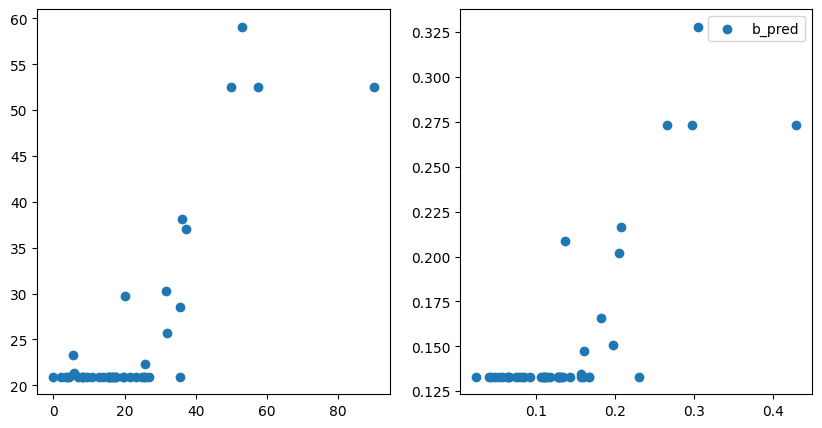

(tensor([[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.2894, 0.1673],
         [0.0278, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [2.3257, 2.2712],
         [0.5343, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.4669, 0.2087],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [1.9276, 1.6351],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.9834, 0.9709],
         [0.0000, 0.0000],
         [0.5694, 0.3839],
         [0.0000, 0.0000],
         [1.9276, 1.6351],
         [0.1454, 0.0000],
         [0.0000, 0.0000],
         [1.9276, 1.6351],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0830, 0.0186],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [1.0477, 0.8005],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
 

In [170]:
p.train(1000)

p.test()